In [2]:
import sys, os
import matplotlib.pyplot as plt
import requests
import json
import pandas as pd
from pandas.io import sql
from pandas.io.json import json_normalize
import numpy as np
from sqlalchemy import types, create_engine
from datetime import date, timedelta
from datetime import datetime
import time
import re
import pylab as py
from matplotlib import gridspec
import matplotlib.dates as md
from sklearn.model_selection import LeaveOneOut
os.environ['PROJ_LIB'] = '/home/ehsan/anaconda3/share/proj'
import matplotlib
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [3]:
# ISLAND_code = ['BI']
ISLAND_code = ['MA', 'KO', 'MO', 'LA']
# ISLAND_code = ['MA', 'KO', 'MO', 'LA', 'KA', 'OA', 'BI']
DATE = "2014-03-27"

In [4]:
# calculate bic for regression
def calculate_bic(n, mse, num_params):
    bic = n * np.log(mse) + num_params * np.log(n)
    return bic

# calculate aic for regression
def calculate_aic(n, mse, num_params):
    aic = n * np.log(mse) + 2 * num_params
    return aic

def metrics(y1, y2, verbose=True, n_param=1):
    '''
    y1 and y2 are two series of the same size

    This function outputs the MAE, RMSE and R^2 
    of the cross evaluated series.

    '''
    y1 = y1.reshape(-1)
    y2 = y2.reshape(-1)
    
    n = len(y1)

    mse = np.mean((y1-y2)**2)

    RMSE = np.sqrt(mse)
    MAE = np.mean(np.abs(y1-y2))
    R2 = np.max([r2_score(y1, y2),r2_score(y2, y1)])
    
    BIC = calculate_bic(n, mse, n_param)
    AIC = calculate_aic(n, mse, n_param)

    if verbose:
        print('MAE: %.2f'%MAE, ' RMSE: %.2f'%RMSE, ' R^2: %.2f'%R2)
        print('AIC: %.2f'%AIC, ' BIC: %.2f'%BIC)

    return MAE, RMSE, R2, AIC, BIC


In [5]:
pr = pd.read_csv("tmax_predictors.csv", encoding = "ISO-8859-1", engine='python')

pr = pr.set_index("SKN")
pr = pr[(pr.Island.isin(ISLAND_code))]

pr.head(5)

,Island,albedo,coastDist,dem_250,lai,rf,tpi,windSpeed,LON,LAT,optional
SKN,,,,,,,,,,,
249.1,MA,11.247000,970.460327,28.987511,0.650120,371.260681,-2.449152,2.305186,-156.438849,20.642089,True
253.0,MA,15.175417,6974.857422,1142.119385,0.537577,733.613464,-21.756172,1.551066,-156.342056,20.644222,True
258.6,MA,12.978750,468.906982,18.382671,0.747965,2087.510010,NaN,3.122898,-156.042480,20.662925,True
266.0,MA,15.175417,6725.787598,1319.686890,0.769055,2258.950928,-37.395905,3.594377,-156.151944,20.684167,True
267.0,MA,13.556167,9405.871094,932.056641,0.703230,800.120422,-2.219152,0.884056,-156.355519,20.700140,True


In [6]:
pr = pd.read_csv("tmax_predictors.csv", encoding = "ISO-8859-1", engine='python')

pr = pr.set_index("SKN")
pr = pr[(pr.Island.isin(ISLAND_code))]

pr.head(5)

,Island,albedo,coastDist,dem_250,lai,rf,tpi,windSpeed,LON,LAT,optional
SKN,,,,,,,,,,,
249.1,MA,11.247000,970.460327,28.987511,0.650120,371.260681,-2.449152,2.305186,-156.438849,20.642089,True
253.0,MA,15.175417,6974.857422,1142.119385,0.537577,733.613464,-21.756172,1.551066,-156.342056,20.644222,True
258.6,MA,12.978750,468.906982,18.382671,0.747965,2087.510010,NaN,3.122898,-156.042480,20.662925,True
266.0,MA,15.175417,6725.787598,1319.686890,0.769055,2258.950928,-37.395905,3.594377,-156.151944,20.684167,True
267.0,MA,13.556167,9405.871094,932.056641,0.703230,800.120422,-2.219152,0.884056,-156.355519,20.700140,True


In [7]:
rf = pd.read_csv("2_Partial_Fill_Daily_RF_mm_1990_2020.csv", encoding = "ISO-8859-1", engine='python')

rf.head(5)


,SKN,Station.Name,Observer,Network,Island,ELEV.m.,LAT,LON,NCEI.id,NWS.id,...,X2020.03.28,X2020.03.29,X2020.03.30,X2020.03.31,X2020.04.01,X2020.04.02,X2020.04.03,X2020.04.04,X2020.04.05,X2020.04.06
0,2.00,MANUKA 2,STATE DIV OF FTRY,COOP,BI,534.0,19.108660,-155.825545,USC00516134,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.10,KAHUKU MAUKA,COOP,COOP,BI,957.0,19.108900,-155.746700,USC00512566,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.32,SOUTH KONA 2 2.32,COOP,COOP,BI,647.0,19.107780,-155.789440,USC00518652,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.34,MILOLII 2.34,COOP,COOP,BI,280.0,19.186302,-155.886763,USC00516304,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.35,HONOMALINO 2.35,COOP,COOP,BI,610.0,19.201000,-155.843000,USC00511922,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
Date = pd.to_datetime(DATE)

meta_columns = ['SKN', 'Station.Name', 'Observer', 'Network', 'Island', 'ELEV.m.',
       'LAT', 'LON', 'NCEI.id', 'NWS.id', 'NESDIS.id', 'SCAN.id',
       'SMART_NODE_RF.id']
Temp_columns = rf.columns[13:]

rf2 = rf[meta_columns]
rf2 = rf2.set_index("SKN")

rf2 = rf2[(rf2.Island.isin(ISLAND_code))]

rf1 = rf[["SKN"]+list(Temp_columns)].T

new_header = rf1.iloc[0]
rf1 = rf1[1:] 
rf1.columns = new_header 

rf1.index = pd.to_datetime([x.split('X')[1] for x in rf1.index.values])
rf1.index.name = 'Date'

rf1 = rf1[list(rf2.index.values)]

# ### generating the rolling average of temperature for 3 days
# rf1_ = rf1.resample('1d').nearest(limit=3).interpolate(method='linear', 
#                                                                 limit=6,
#                                                                limit_direction='forward')
rf1_mean3 = rf1.rolling('3d', min_periods=3).mean()
rf1_mean7 = rf1.rolling('7d', min_periods=7).mean()
rf1_mean15 = rf1.rolling('15d', min_periods=10).mean()
rf1_mean30 = rf1.rolling('30d', min_periods=15).mean()
rf1_mean60 = rf1.rolling('60d', min_periods=30).mean()
rf1_mean90 = rf1.rolling('90d', min_periods=45).mean()
rf1_mean120 = rf1.rolling('120d', min_periods=60).mean()
rf1_mean180 = rf1.rolling('180d', min_periods=90).mean()


rf3 = rf2[["LON", "LAT", "ELEV.m."]].T
rf3 = rf3[list(rf2.index.values)]

rf_station = rf3.T

rf_station = rf_station.join(rf1.T[[Date]].rename(columns={Date: 'RF'}), how='left')
rf_station = rf_station.join(rf1_mean3.T[[Date]].rename(columns={Date: 'RF3'}), how='left')
rf_station = rf_station.join(rf1_mean7.T[[Date]].rename(columns={Date: 'RF7'}), how='left')
rf_station = rf_station.join(rf1_mean15.T[[Date]].rename(columns={Date: 'RF15'}), how='left')
rf_station = rf_station.join(rf1_mean30.T[[Date]].rename(columns={Date: 'RF30'}), how='left')
rf_station = rf_station.join(rf1_mean60.T[[Date]].rename(columns={Date: 'RF60'}), how='left')
rf_station = rf_station.join(rf1_mean90.T[[Date]].rename(columns={Date: 'RF90'}), how='left')
rf_station = rf_station.join(rf1_mean120.T[[Date]].rename(columns={Date: 'RF120'}), how='left')
rf_station = rf_station.join(rf1_mean180.T[[Date]].rename(columns={Date: 'RF180'}), how='left')
data_rf = rf_station[["RF", "RF3", "RF7", "RF15", "RF30", "RF60", "RF90", "RF120", "RF180"]].dropna()

# data_rf = data_rf.rename(columns={Date: 'RF'})

data_rf

,RF,RF3,RF7,RF15,RF30,RF60,RF90,RF120,RF180
SKN,,,,,,,,,
249.1,0.00000,2.775558e-15,0.728571,0.766667,3.596667,3.531255,3.339670,2.725833,1.975555
250.0,0.50800,1.693333e-01,1.705429,1.608667,4.605867,3.835400,4.219222,4.315883,3.402189
253.0,0.00000,5.080000e-01,1.161143,0.660400,6.019800,5.240867,5.460978,5.281050,3.953900
255.0,6.09600,4.826000e+00,2.068286,0.965200,2.878667,2.671233,2.489200,2.159000,1.571978
258.6,6.63174,4.366327e+00,6.342707,5.642915,5.608151,4.504483,4.459822,4.557129,4.370711
...,...,...,...,...,...,...,...,...,...
536.5,0.00000,9.313333e-01,1.560286,1.337733,3.589867,3.869267,3.603978,3.246967,2.356556
538.0,2.54000,4.064000e+00,6.122857,8.377600,8.566067,9.303767,9.157378,7.799367,5.765433
541.2,10.16000,1.439333e+01,63.137143,56.388000,34.120667,31.484667,25.858111,20.595850,15.922044


In [9]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

<ipython-input-10-f10ba65d31b4>:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(gs[1]).set_title("SKN: "+str(dfp.columns[10]))


Text(0, 0.5, 'Precipitation [mm]')

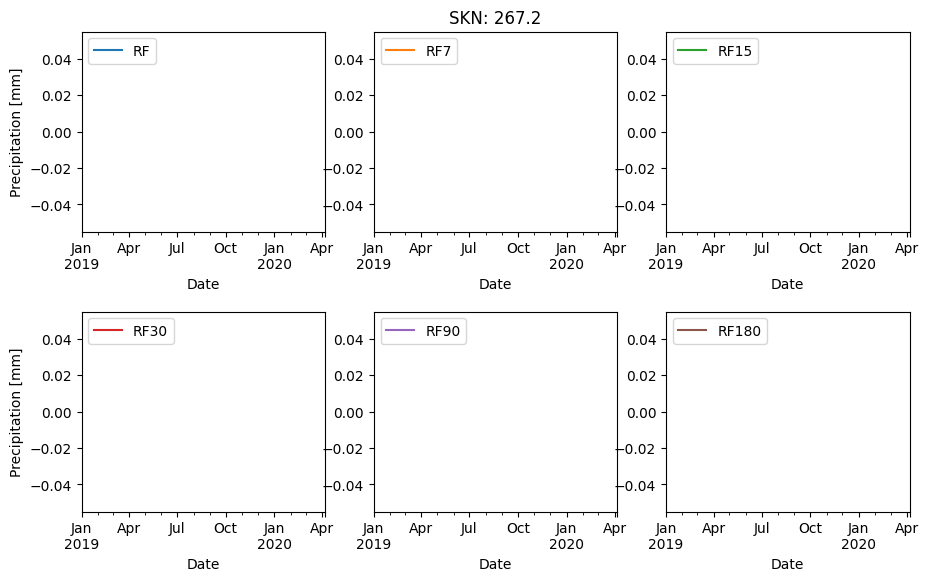

In [10]:
fig = py.figure(figsize=(9, 6), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
gs = gridspec.GridSpec(2,3) ; p=0

ax_list = []

for i in range(6):
    g = gs[i]
    ax_list.append(plt.subplot(g))
    
i = 0 
dfp = rf1
dfp.index = pd.to_datetime(dfp.index)
dfp.loc["2019":"2020"][[dfp.columns[10]]].plot(ax=ax_list[i], color=colors[i])
ax_list[i].legend(["RF"], loc=2)

i+=1
dfp = rf1_mean7
dfp.index = pd.to_datetime(dfp.index)
dfp.loc["2019":"2020"][[dfp.columns[10]]].plot(ax=ax_list[i], color=colors[i])
ax_list[i].legend(["RF7"], loc=2)

i+=1
dfp = rf1_mean15
dfp.index = pd.to_datetime(dfp.index)
dfp.loc["2019":"2020"][[dfp.columns[10]]].plot(ax=ax_list[i], color=colors[i])
ax_list[i].legend(["RF15"], loc=2)

i+=1 
dfp = rf1_mean30
dfp.index = pd.to_datetime(dfp.index)
dfp.loc["2019":"2020"][[dfp.columns[10]]].plot(ax=ax_list[i], color=colors[i])
ax_list[i].legend(["RF30"], loc=2)

i+=1
dfp = rf1_mean90
dfp.index = pd.to_datetime(dfp.index)
dfp.loc["2019":"2020"][[dfp.columns[10]]].plot(ax=ax_list[i], color=colors[i])
ax_list[i].legend(["RF90"], loc=2)

i+=1
dfp = rf1_mean180
dfp.index = pd.to_datetime(dfp.index)
dfp.loc["2019":"2020"][[dfp.columns[10]]].plot(ax=ax_list[i], color=colors[i])
ax_list[i].legend(["RF180"], loc=2)


plt.subplots_adjust(hspace=0.4, wspace=0.2)


plt.subplot(gs[1]).set_title("SKN: "+str(dfp.columns[10]))

ax_list[0].set_ylabel("Precipitation [mm]")
ax_list[3].set_ylabel("Precipitation [mm]")

In [21]:
df = pd.read_csv("Tmax_QC.csv", encoding = "ISO-8859-1", engine='python')

meta_columns = ['SKN', 'Station.Name', 'Observer', 'Network', 'Island', 'ELEV.m.',
       'LAT', 'LON', 'NCEI.id', 'NWS.id', 'NESDIS.id', 'SCAN.id',
       'SMART_NODE_RF.id']
Temp_columns = df.columns[13:]

df2 = df[meta_columns]
df2 = df2.set_index("SKN")

df2 = df2[((df2.Island.isin(ISLAND_code)) | (df2["ELEV.m."]>2000))]


df2.head(10)

,Station.Name,Observer,Network,Island,ELEV.m.,LAT,LON,NCEI.id,NWS.id,NESDIS.id,SCAN.id,SMART_NODE_RF.id
SKN,,,,,,,,,,,,
39.0,Mauna Loa Observatory,NWS,ESRL/GMD,BI,3397.0000,19.536200,-155.576300,USC00516198,MOBH1,NaN,NaN,NaN
39.1,Mauna Loa Upper,NWS,STATE,BI,3341.0000,19.538633,-155.572221,NaN,NaN,NaN,NaN,NaN
39.2,MAUNA LOA 5 NNE,MAUNA LOA 5 NNE,USCRN,BI,3398.0000,19.535400,-155.576000,USW00021514,MLBH1,CD07379A,NaN,NaN
102.8,AUHMOA,RAWS,RAWS,BI,2001.9264,19.836389,-155.613056,NaN,AHMH1,4870D3B2,NaN,NaN
113.2,PUU MALI,RAWS,RAWS,BI,2165.0000,19.926660,-155.440000,NaN,PMLH1,3181742E,NaN,NaN
249.1,MAKENA GOLF CRS 249.1,MAKE GC,COOP,MA,30.0000,20.642089,-156.438849,USC00515842,NaN,NaN,NaN,NaN
253.0,AUWAHI HN-141,HaleNet,HaleNet,MA,1166.0000,20.644222,-156.342056,NaN,NaN,NaN,NaN,NaN
258.6,OHE'O 258.6,HALEAKALA TL PK,COOP,MA,24.0000,20.662925,-156.042480,USC00517000,NaN,NaN,NaN,NaN
266.0,KAUPO GAP,RAWS,RAWS,MA,1228.3440,20.684167,-156.151944,USR0000HKAU,KPGH1,FA45A6E0,NaN,NaN


In [16]:


df1 = df[["SKN"]+list(Temp_columns)].T

new_header = df1.iloc[0]
df1 = df1[1:] 
df1.columns = new_header 

df1.index = pd.to_datetime([x.split('X')[1] for x in df1.index.values])
df1.index.name = 'Date'

df1 = df1[list(df2.index.values)]


df3 = df2[["LON", "LAT", "ELEV.m."]].T
df3 = df3[list(df2.index.values)]

df_station = df3.T
df_station = df_station.join(df1.T, how='left')

Date = pd.to_datetime(DATE)
data_df = df_station[["LON", "LAT", "ELEV.m.", Date]]#.dropna()

data_df = data_df.rename(columns={Date: 'T'})

df = data_df.join(data_rf, how='left', lsuffix='_T', rsuffix='_RF')#.dropna()

df = df.join(pr[pr.columns[:-3]], how='left')#.dropna()

print(len(df))
df.head(5)

54


,LON,LAT,ELEV.m.,T,RF,RF3,RF7,RF15,RF30,RF60,...,RF120,RF180,Island,albedo,coastDist,dem_250,lai,rf,tpi,windSpeed
SKN,,,,,,,,,,,,,,,,,,,,,
249.1,-156.438849,20.642089,30.000,28.30,0.00000,2.775558e-15,0.728571,0.766667,3.596667,3.531255,...,2.725833,1.975555,MA,11.247000,970.460327,28.987511,0.650120,371.260681,-2.449152,2.305186
253.0,-156.342056,20.644222,1166.000,19.80,0.00000,5.080000e-01,1.161143,0.660400,6.019800,5.240867,...,5.281050,3.953900,MA,15.175417,6974.857422,1142.119385,0.537577,733.613464,-21.756172,1.551066
258.6,-156.042480,20.662925,24.000,NaN,6.63174,4.366327e+00,6.342707,5.642915,5.608151,4.504483,...,4.557129,4.370711,MA,12.978750,468.906982,18.382671,0.747965,2087.510010,NaN,3.122898
266.0,-156.151944,20.684167,1228.344,22.22,9.65200,1.397000e+01,7.293429,3.640667,9.609667,7.996767,...,8.009683,5.739133,MA,15.175417,6725.787598,1319.686890,0.769055,2258.950928,-37.395905,3.594377
267.0,-156.355519,20.700140,916.000,21.70,0.00000,0.000000e+00,1.857143,1.886667,5.123993,5.881176,...,5.109649,3.713529,MA,13.556167,9405.871094,932.056641,0.703230,800.120422,-2.219152,0.884056


In [12]:
df2

,Station.Name,Observer,Network,Island,ELEV.m.,LAT,LON,NCEI.id,NWS.id,NESDIS.id,SCAN.id,SMART_NODE_RF.id
SKN,,,,,,,,,,,,
249.10,MAKENA GOLF CRS 249.1,MAKE GC,COOP,MA,30.0000,20.642089,-156.438849,USC00515842,NaN,NaN,NaN,NaN
253.00,AUWAHI HN-141,HaleNet,HaleNet,MA,1166.0000,20.644222,-156.342056,NaN,NaN,NaN,NaN,NaN
258.60,OHE'O 258.6,HALEAKALA TL PK,COOP,MA,24.0000,20.662925,-156.042480,USC00517000,NaN,NaN,NaN,NaN
266.00,KAUPO GAP,RAWS,RAWS,MA,1228.3440,20.684167,-156.151944,USR0000HKAU,KPGH1,FA45A6E0,NaN,NaN
267.00,KULA HOSPITAL 267,KULA SATORIUM,COOP,MA,916.0000,20.700140,-156.355519,USC00515004,NaN,NaN,NaN,NaN
267.80,KULA 1,KULA 1,RAWS,MA,1998.5736,20.683056,-156.321667,NaN,KLFH1,AA10F12E,NaN,NaN
276.00,BIG BOG HN-164,HaleNet,HaleNet,MA,1650.0000,20.726556,-156.092250,NaN,NaN,NaN,NaN,NaN
277.00,HORSHOE PU'U HN-163,HaleNet,HaleNet,MA,1930.0000,20.736306,-156.107139,NaN,NaN,NaN,NaN,NaN
278.00,TREE LINE HN-162,HaleNet,HaleNet,MA,2195.0000,20.734222,-156.122889,NaN,NaN,NaN,NaN,NaN


<ipython-input-13-6e047f2f8023>:4: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  map = Basemap(llcrnrlon=-160.5,llcrnrlat=18.5,urcrnrlon=-154.5,urcrnrlat=22.5, projection='cyl')
<ipython-input-13-6e047f2f8023>:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  shp_info = map.readshapefile('st99_d00','states',drawbounds=True,
<ipython-input-13-6e047f2f8023>:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  shp_info_ = map.readshapefile('st99_d00','states',drawbounds=False)


Text(-157.55, 20.74, 'Lanai')

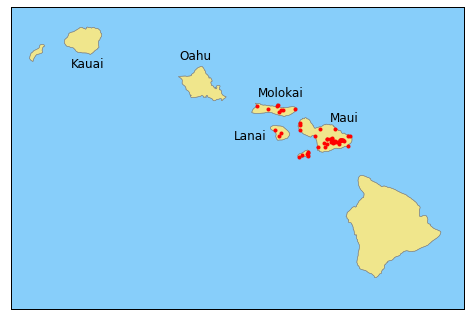

In [13]:
fig=plt.figure(figsize=(7,7))
ax = fig.add_axes([0.05,0.05,0.9,0.9])

map = Basemap(llcrnrlon=-160.5,llcrnrlat=18.5,urcrnrlon=-154.5,urcrnrlat=22.5, projection='cyl')

shp_info = map.readshapefile('st99_d00','states',drawbounds=True,
                           linewidth=0.45,color='gray')
shp_info_ = map.readshapefile('st99_d00','states',drawbounds=False)

map.drawmapboundary(fill_color='lightskyblue')

for lon, lat in list(zip(df2.LON.values, df2.LAT.values)):
    
    x, y = map(lon, lat)
    map.plot(x, y, marker='o',color='red',markersize=3)

# x, y = map(df2.loc[55.1].LON, df2.loc[55.1].LAT)
# map.plot(x, y, marker='o',color='red',markersize=3)
    
for nshape, shapedict in enumerate(map.states_info):
     if shapedict['NAME'] in ['Hawaii']:
         seg = map.states[int(shapedict['SHAPENUM'] - 1)]
         poly = Polygon(seg, facecolor='khaki', edgecolor='gray', linewidth=.45)
         ax.add_patch(poly)

        
ax.annotate("Oahu",(-158.27,21.8), fontsize=12)
ax.annotate("Maui",(-156.28,20.98), fontsize=12)
# ax.annotate("Hawaii",(-155.3,20.2), fontsize=12)
ax.annotate("Molokai",(-157.23,21.31), fontsize=12)
ax.annotate("Kauai",(-159.7,21.7), fontsize=12)
ax.annotate("Lanai",(-157.55,20.74), fontsize=12)

# ax.annotate("HAWAII",(-160.24,18.75), fontsize=16)

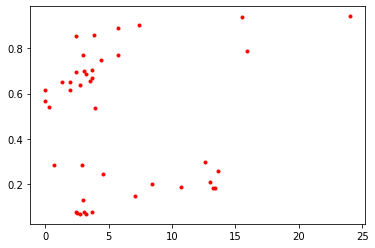

In [14]:
y = df["lai"].values
x = df["RF180"].values

plt.plot(x, y, 'r.')



In [343]:
from scipy.optimize import minimize
import george
from george import kernels
from sklearn.model_selection import KFold

In [344]:
# X = df[["LON", "LAT", "ELEV.m.", "coastDist", "lai", "tpi", "dem_250"]].values

df = df[["T", "LON", "LAT", "ELEV.m."]].dropna()
X = df[["LON", "LAT", "ELEV.m."]].values
y = df['T'].values

In [345]:
len(df)

36

1.8592866238399373
1.8592866238399373


Text(0.5, 1.0, 'Big Island (1995-08-15)')

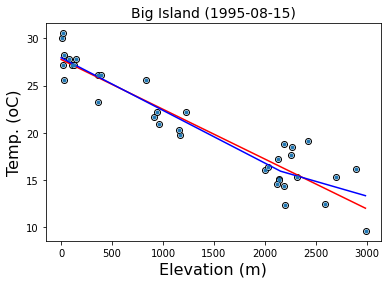

In [346]:
from scipy.optimize import curve_fit

def linear(x, a, b):
    return a*x+b

def bilinear(x, a, b, c):
    
    left  = a*x+b
    right = c*(x-2150) + (a*2150+b) 
    
    try:
        y = np.asarray([left[i] if x[i]<=2150 else right[i] for i in range(len(x))])
        return y
    except:
        if x<=2150:
            return left
        else:
            return right

plt.plot(X[:,2], y, 'ko', mfc='white')




u = np.arange(np.round(np.max(X[:,2])))

fit, cov = curve_fit(linear, X[:,2], y, sigma=y*0+1)
v1 = linear(u, fit[0], fit[1])

fit, cov = curve_fit(bilinear, X[:,2], y, sigma=y*0+1)



model = bilinear(X[:,2], fit[0], fit[1], fit[2])

# indx, = np.where(np.abs(model-y)<3)

stdev = np.std(model-y) ; print(stdev)
indx, = np.where(np.abs(model-y)<2.5*stdev)

fit, cov = curve_fit(bilinear, X[:,2][indx], y[indx], sigma=y[indx]*0+1)


model = bilinear(X[:,2], fit[0], fit[1], fit[2])

# indx, = np.where(np.abs(model-y)<3)
stdev = np.std(model-y)  ; print(stdev)
indx, = np.where(np.abs(model-y)<2.5*stdev)


fit, cov = curve_fit(bilinear, X[:,2][indx], y[indx], sigma=y[indx]*0+1)

plt.plot(u, v1, 'r-')

v2 = bilinear(u, fit[0], fit[1], fit[2])
plt.plot(u, v2, 'b-')

plt.plot(X[:,2][indx], y[indx], '.')

plt.xlabel("Elevation (m)", fontsize=16)
plt.ylabel("Temp. (oC)", fontsize=16)

plt.title("Big Island (1995-08-15)", fontsize=14)

In [347]:
def nll_fn2(X, y):
    
    def step(theta):
        
#         kf = KFold(n_splits=3)
        loo = LeaveOneOut()
        i=0
        
        for train_index, test_index in loo.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
        
            N = X_train.shape[0]
            
            zp = theta[0]
            slope = theta[1]
            s2 = theta[2]

            s3 = theta[3]
            s4 = theta[4]
            
            y_model_test = slope*X_test[:,2] + zp + s3*X_test[:,3] + s4*X_test[:,4]+theta[5]*X_test[:,5]
            ind, = np.where(X_test[:,2]>2150)
            y_model_test[ind] += s2*(X_test[:,2][ind]-2150)  
            
            delta = np.abs(y_model_test - y_test)
            
            
            if i==0:
                XI2 = delta**2
            else:
                XI2 = np.concatenate((XI2, delta**2))
            
            i+=1
#             print(XI2)
            
            

    
        return np.sum(XI2)
    
    
    return step


# Maximum Likelihood
pos = minimize(nll_fn2(X[indx], y[indx]), [0, -0.002, 0, 0, 0, 0, 0], method='L-BFGS-B')
print(pos)

IndexError: index 3 is out of bounds for axis 1 with size 3

In [ ]:
def func(X, *theta):
    
    n_data, n_params= X.shape

    y = theta[1] * X[:, 2] + theta[0]
    for t in range(3, n_params):
        y += theta[t]*X[:, t]

    ind, = np.where(X[:, 2] > 2150)
    y[ind] += theta[2] * (X[:, 2][ind] - 2150)
    
    return y
    

In [ ]:
from scipy.optimize import curve_fit
fit, cov = curve_fit(func, X[indx], y[indx], p0=[30, -0.002, 0, 0, 0, 0,0])

fit, cov

In [ ]:
# plt.plot(df3.iloc[2].values, df1.loc[Date].values, 'ko', mfc='none')
plt.plot(X[:,2], y, 'o', mfc='white', mec='k')
plt.plot(X[:,2][indx], y[indx], 'k.')


theta = fit
loo = LeaveOneOut()

X0 = X[indx]
y0 = y[indx]


loo = LeaveOneOut()
n_data, n_params = X.shape

u = np.zeros(n_data)
v = np.zeros(n_data)
i = 0
u=[]
v = []

uloo = []

for train_index, test_index in loo.split(X0):

    X_train, X_test = X0[train_index], X0[test_index]
    y_train, y_test = y0[train_index], y0[test_index]

    y_mod = func(X_test, *fit)
    
    f, _ = curve_fit(func, X_train, y_train, p0=[30, -0.002, 0, 0, 0, 0,0])
    y_loo = func(X_test, *f)


    plt.plot(X_test[:,2], y_mod , 'ro')
    plt.plot(X_test[:,2], y_loo , 'bo')
    
    u.append(y_mod[0])
    v.append(y_test[0])
    uloo.append(y_loo[0])

    i += 1
    
u = np.asarray(u)
uloo = np.asarray(uloo)
v = np.asarray(v)
    
plt.xlabel("Elevation [meter]", fontsize=14)
plt.ylabel("Temperature [oC]", fontsize=14)

plt.xlim(0,2500)
plt.ylim(15,30)

In [ ]:
fig = plt.figure(figsize=(6,5), dpi=80)


plt.plot(v, uloo, 'bo',mfc='white', ms=7, label='Leave-One-Out scatter')
plt.plot(v, u, 'ro', label='All-in Scatter')


plt.xlim(0,35)
plt.ylim(0,35)

plt.plot([0,35], [0,35], ':')

plt.ylabel("Temp. MODEL [oC]", fontsize=15)
plt.xlabel("Temp. [Observed] [oC]", fontsize=15)
plt.title("Big Island (1995-08-15)", fontsize=16)
metrics(u, v, n_param=7)
metrics(uloo, v, n_param=7)

plt.xlim(20,30)
plt.ylim(20,30)

plt.legend(fontsize=12)

In [22]:
df.head(5)

,LON,LAT,ELEV.m.,T,RF,RF3,RF7,RF15,RF30,RF60,...,RF120,RF180,Island,albedo,coastDist,dem_250,lai,rf,tpi,windSpeed
SKN,,,,,,,,,,,,,,,,,,,,,
3.9,-155.669722,19.100833,953.7192,21.67,0.000000,0.333333,0.285714,2.000000e-01,1.533333,3.150000,...,3.533333,3.094444,BI,12.331667,12794.167969,930.497986,0.794778,1607.603271,-0.835584,2.833071
9.2,-155.125833,19.348056,710.4888,20.00,0.000000,0.000000,0.071429,3.333333e-02,1.343333,2.818333,...,2.715367,2.203263,BI,11.683500,6832.974609,706.599365,0.668505,2738.473389,-0.192528,2.934816
21.3,-155.488610,19.206670,332.0000,27.20,0.101023,0.179161,0.076783,3.583213e-02,1.359233,4.820755,...,5.335705,4.132366,BI,14.870334,7397.353027,362.006073,0.878270,1493.430908,-4.092196,1.727876
23.0,-155.780000,19.232222,1796.4912,22.78,0.000000,0.000000,0.000000,7.579123e-15,2.233333,1.233333,...,1.814167,1.592222,BI,10.935417,12784.630859,1765.574707,0.429247,886.509338,-0.460424,1.307876
24.1,-155.873877,19.270322,396.0000,26.10,0.000000,0.000000,0.000000,0.000000e+00,3.896667,2.488333,...,2.625000,2.560000,BI,11.683500,2378.271973,430.339142,0.820525,1079.461548,-0.442420,0.919179


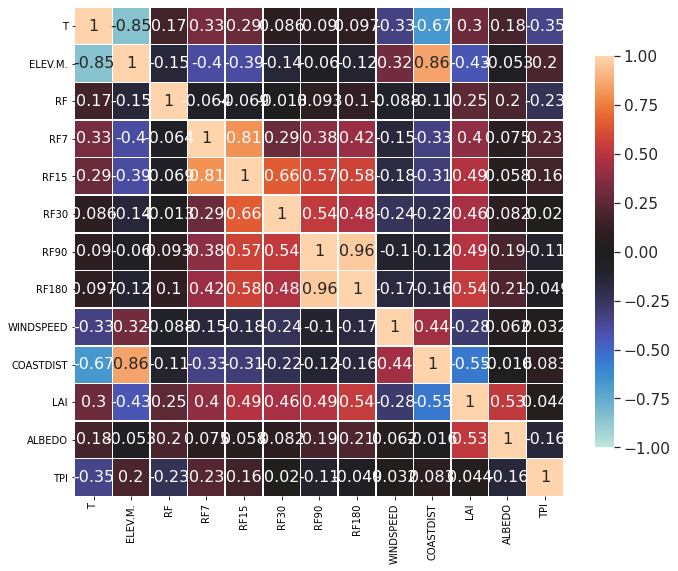

In [23]:
import seaborn as sns
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

d = {}
for col in df.columns:
    d[col] = col.upper()

L = ["T", "ELEV.m.", "RF", "RF7", "RF15", "RF30", "RF90", "RF180",
     "windSpeed", "coastDist", "lai", "albedo", "tpi"]
df_ = df[L]
df_ = df_.rename(columns=d)

corr = df_.dropna().corr()

### Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

### Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

sns.set(font_scale=1.4)

### Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, vmin=-1,vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot_kws={"size": 16}, annot=True) # , mask=mask)



In [24]:
corr["T"]

T            1.000000
ELEV.M.     -0.848616
RF           0.169687
RF7          0.330480
RF15         0.294434
RF30         0.086312
RF90         0.089951
RF180        0.096530
WINDSPEED   -0.332109
COASTDIST   -0.669737
LAI          0.298383
ALBEDO       0.184564
TPI         -0.347624
Name: T, dtype: float64

In [25]:
a = np.zeros((1,2,3))

a.shape

(1, 2, 3)

In [26]:
import copy

i = 0
n = len(dt_cols)

for dt_col in dt_cols:
    
    try:
    
        DATE = str(dt_col.date())

        Date = pd.to_datetime(DATE)
        rf_station = rf3.T
        rf_station = rf_station.join(rf1.T[[Date]].rename(columns={Date: 'RF'}), how='left')
        rf_station = rf_station.join(rf1_mean3.T[[Date]].rename(columns={Date: 'RF3'}), how='left')
        rf_station = rf_station.join(rf1_mean7.T[[Date]].rename(columns={Date: 'RF7'}), how='left')
        rf_station = rf_station.join(rf1_mean15.T[[Date]].rename(columns={Date: 'RF15'}), how='left')
        rf_station = rf_station.join(rf1_mean30.T[[Date]].rename(columns={Date: 'RF30'}), how='left')
        rf_station = rf_station.join(rf1_mean60.T[[Date]].rename(columns={Date: 'RF60'}), how='left')
        rf_station = rf_station.join(rf1_mean90.T[[Date]].rename(columns={Date: 'RF90'}), how='left')
        rf_station = rf_station.join(rf1_mean120.T[[Date]].rename(columns={Date: 'RF120'}), how='left')
        rf_station = rf_station.join(rf1_mean180.T[[Date]].rename(columns={Date: 'RF180'}), how='left')
        data_rf = rf_station[["RF", "RF7", "RF15", "RF30", "RF90", "RF180"]].dropna()

        data_df = df_station[["LON", "LAT", "ELEV.m.", Date]].dropna()
        data_df = data_df.rename(columns={Date: 'T'})
        df = data_df.join(data_rf, how='left', lsuffix='_T', rsuffix='_RF').dropna()
        df = df.join(pr[pr.columns[:-3]], how='left').dropna()

        df_ = df[L]
        df_ = df_.rename(columns=d)

        corr = df_.dropna().corr()

        if i==0:
    #         corr_add = copy.deepcopy(corr)
            p, q = corr.shape
            corr_add = np.zeros((p, q, n))
            corr_add[:] = np.NaN
            corr_add[:,:,i] = corr
        else:
    #         corr_add = corr_add.add(corr, fill_value=0)
            corr_add[:,:,i] = corr

        print(i, DATE)
        i+=1
    except:
        pass
    
#     if i==10: break

NameError: name 'dt_cols' is not defined

In [ ]:
corr_mean = copy.deepcopy(corr)
Cmean = np.nanmean(corr_add, axis=2)

i = 0
for col in corr_mean.columns:
    
    corr_mean[col] = Cmean[:,i]
    i+=1


In [ ]:
Cmean

In [ ]:
corr_mean

In [ ]:
### Generate a mask for the upper triangle
mask = np.zeros_like(corr_mean, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

### Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

sns.set(font_scale=1.4)

### Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_mean, vmin=-1,vmax=1.0, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot_kws={"size": 10}, annot=True) # , mask=mask)



In [ ]:
corr_mean["T"] = np.abs(corr_mean["T"].values)
ax = corr_mean.plot.bar(y='T', colormap='Paired', color=plt.cm.Set1(corr_mean["T"].values))

ax.set_ylabel("Correlation")
ax.set_title("T(max)")